In [ ]:
import cv2
import os
import matplotlib
from matplotlib import pyplot as plt
from shutil import copyfile, copy

In [ ]:
print(cv2.__version__)
print(matplotlib.__version__)

4.1.2
3.2.2


In [ ]:
!ls

cw_data.zip  sample_data


In [ ]:
# mount your local drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# list the contents of your drive and the lab data directory
!ls /content/drive/MyDrive/DATA

# then to say read an image called 'some-image.png' you need to do something like this 
data_dir = 'drive/MyDrive/DATA/'
#im = cv2.read(data_dir + 'some-image.png')

test-001.jpeg  test-007.jpeg  train-004.jpg  train-010.jpg   video-002.MOV
test-002.jpeg  test-009.jpeg  train-005.jpg  train-012.jpg   video-002.webm
test-003.jpeg  test-010.jpeg  train-006.jpg  train-013.jpg
test-004.jpeg  train-001.jpg  train-007.jpg  train-014.jpg
test-005.jpeg  train-002.jpg  train-008.jpg  video-001.MOV
test-006.jpeg  train-003.jpg  train-009.jpg  video-001.webm


In [ ]:
#specify data directory and results directory
data_dir = 'drive/MyDrive/DATA'
results_dir = 'drive/MyDrive/RESULTS'

In [ ]:
#helper function to create custom directories
def create_dir(dir_path):
    try:
        os.mkdir(dir_path)
    except:
        pass

In [ ]:
#create directory to store intermediate/final results
create_dir(results_dir)

# 1. Cropping individual cards from scanned images

The below cells highlight in a step by step manner how the cards are cropped out of the scanned image using image processing techniques. The objective is to identify the boundary of each card - the processing steps manipulate the original image to achieve this. 

Once the boundary has been identified, the card can be cropped out of the original image to get a crop that doesn't lose any information (such as color).

In [ ]:
#read sample scanned image
img = cv2.imread(os.path.join(data_dir, 'train-002.jpg'))
#convert from BGR to RGB space for display purposes
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#create copies of the image to draw on at later stage
img2 = img.copy()
img3 = img.copy()

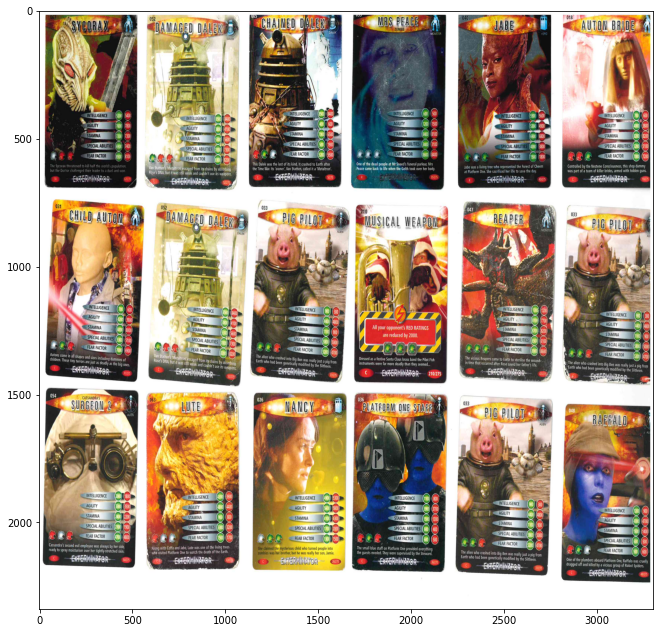

In [ ]:
#display original image
plt.figure(figsize = (11,11))
plt.imshow(img, aspect='auto')
plt.show()

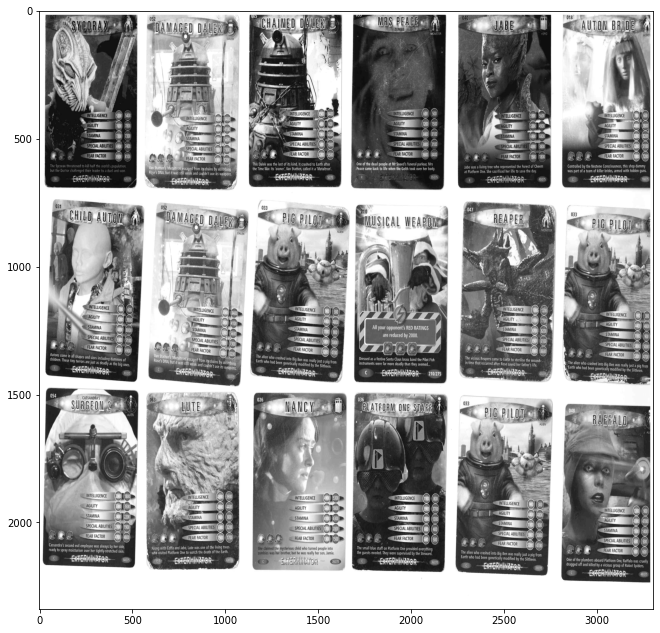

In [ ]:
#convert RGB image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize = (11,11))
plt.imshow(gray, aspect='auto', cmap='gray')
plt.show()

### Binarization

From the grayscale image, it is clear that the background is white and the cards stand out against it. With the help of binarization, this contrast should become more pronounced.

A high threshold value is used so that only really white (background) pixels remain white and the rest (card-pixels) are represented as black pixels.

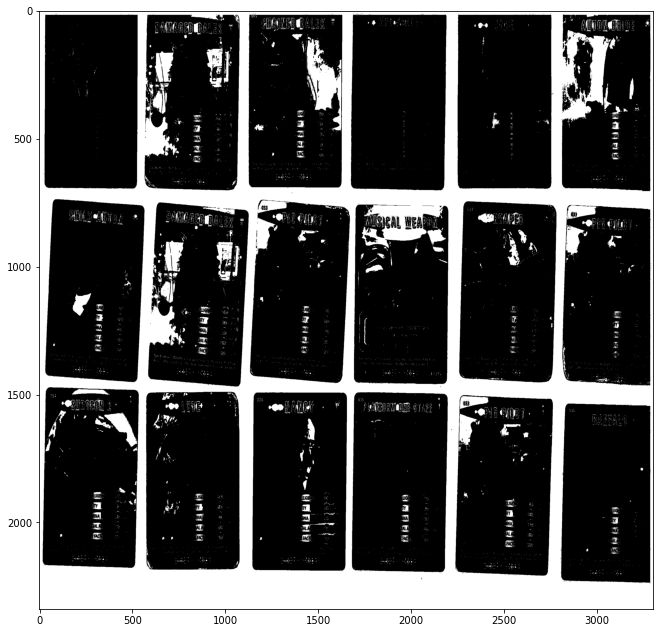

In [ ]:
#binarize the grayscale image
ret,thresh = cv2.threshold(gray,240,255,cv2.THRESH_BINARY)
plt.figure(figsize = (11,11))
plt.imshow(thresh, aspect='auto', cmap='gray')
plt.show()

### Contour detection

Next, contour detection is performed with the expectation that it will identify the boundaries of each card.

As seen in the below example, the detection is not perfect but does a decent job of identifying the boundary where there is good contrast against the background.

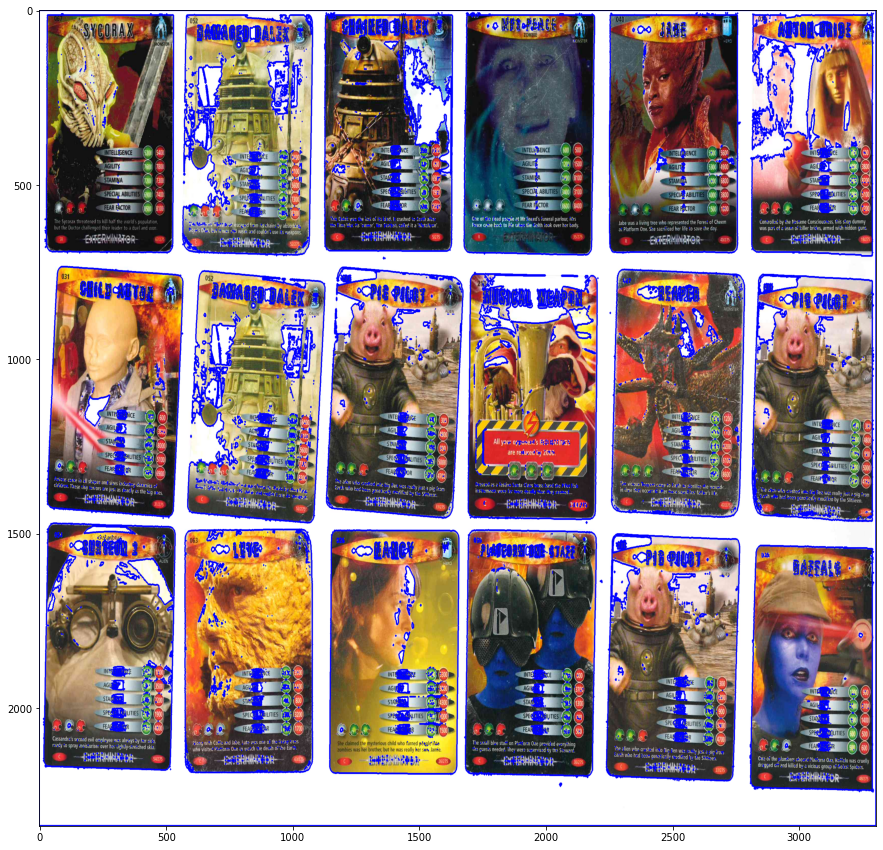

In [ ]:
contours, heirarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img2, contours, -1, (0,0,255), 3)

plt.figure(figsize = (15,15))
plt.imshow(img2, aspect='auto')
plt.show()

### Sort Contours

The contours are sorted so that larger contours (ideally the cards) can be focussed on. A threshold can be identified and set with experimentation to ignore contours that are either too large or too small.

One of the larger contours is displayed below for reference.

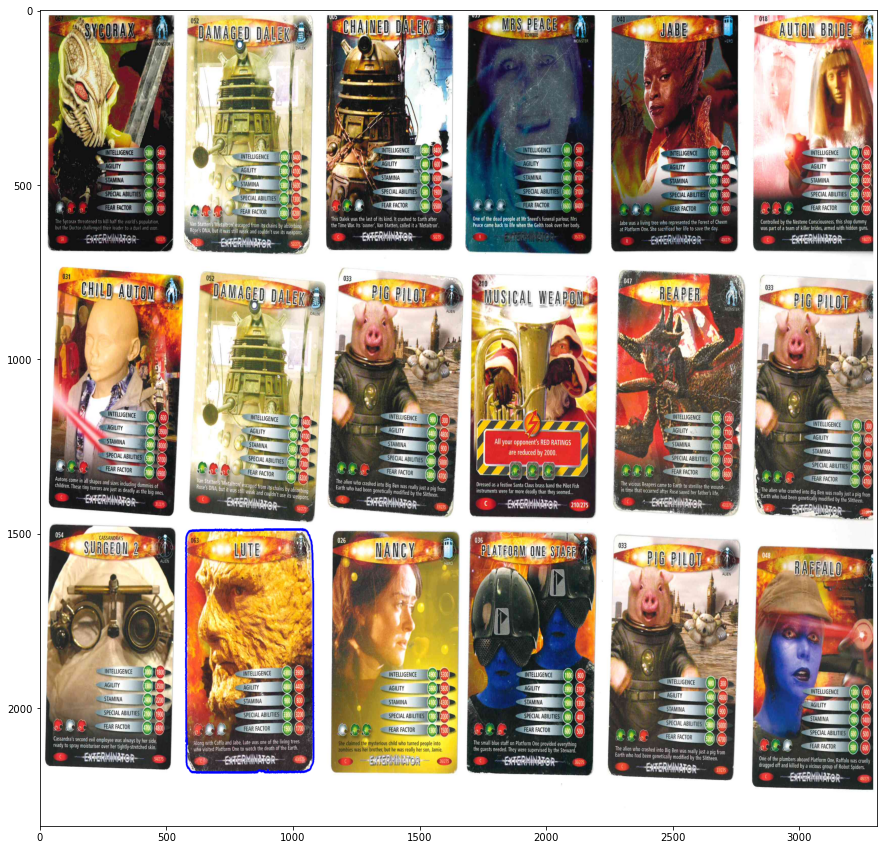

In [ ]:
cntsSorted = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
cnt = cntsSorted[5]

cv2.drawContours(img3, [cnt], 0, (0,0,255), 5)
plt.figure(figsize = (15,15))
plt.imshow(img3, aspect='auto')
plt.show()

### Convert contour to Box

The most extreme points of the contour are used to compute a rectangular box for it. This rectangle's coordinates are used to crop out the card.

The below image shows the earlier detected contour in `Blue` and the corresponding box in `Red`.

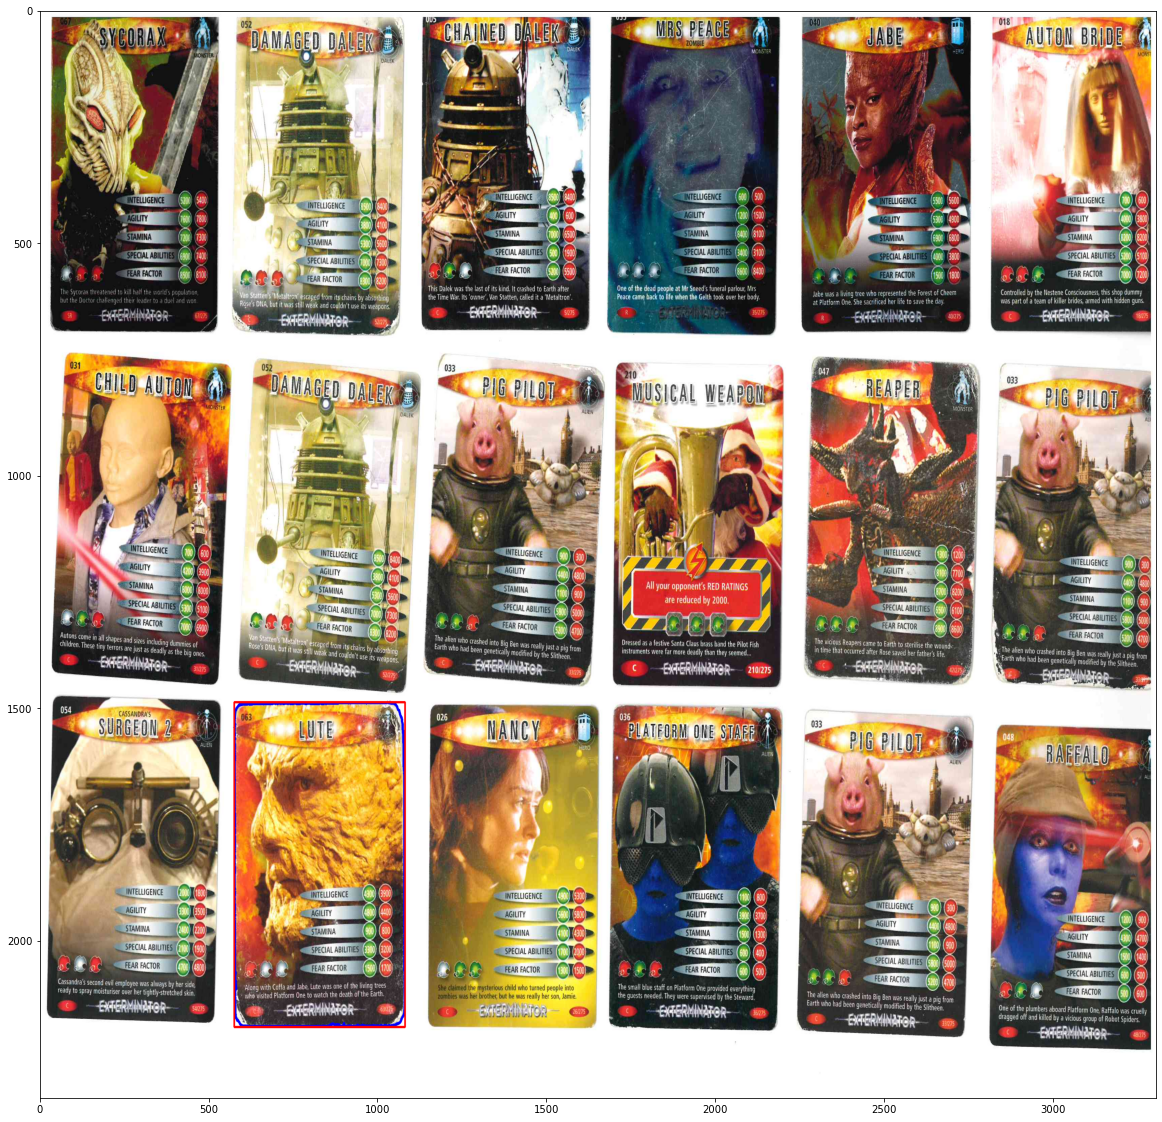

In [ ]:
x, y, w, h = cv2.boundingRect(cnt)

cv2.rectangle(img3, (x,y), (x+w, y+h), (255,0,0), 3)
plt.figure(figsize = (20,20))
plt.imshow(img3, aspect='auto')
plt.show()

### Crop out the card!

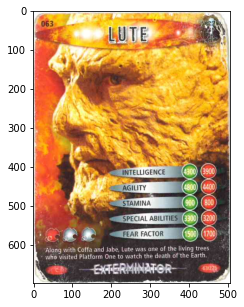

In [ ]:
card = img[y:y+h, x:x+w]
plt.figure(figsize=(5,5))
plt.imshow(card)
plt.show()

# 2. Function to crop out cards

The steps explained above are applied on each of the `train` images to crop out the cards. These will be stored in a new directory called `card_crops` inside the results directory.

In [ ]:
#create directory to store card crops
create_dir(os.path.join(results_dir, 'card_crops'))

In [ ]:
def crop_cards(img_path):
    img = cv2.imread(img_path)
    scan_img_name = os.path.split(img_path)[-1].split('.')[0]
    
    #create directory corresponding to each 'train' image
    write_dir = os.path.join(results_dir, 'card_crops', scan_img_name)
    create_dir(write_dir)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret,thresh = cv2.threshold(gray,240,255,cv2.THRESH_BINARY)
    contours, heirarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #list to store box coordinates of detected cards
    card_boxes = []
    for cont in contours:
        x, y, w, h = cv2.boundingRect(cont)
        #use a threshold to filter out contours that are too large/small
        if w in range(430,630) and h in range(600,850):
            card_boxes.append((x, y, w, h))
      
    print('Found {} cards in image {}'.format(len(card_boxes), os.path.split(img_path)[-1]))
    count = 1
    for item in card_boxes:
        x, y, w, h = item
        cropped = img[y:y+h, x:x+w]
        #write the cropped image to disk
        cv2.imwrite(os.path.join(write_dir, str(count)+'.jpg'), cropped)
        count += 1

In [ ]:
#creating list of 'train' images to crop the cards from
num_list = ['01','02','03','04','05','06','07','08','09','10','12','13','14']
scan_img_list = ['train-0{}.jpg'.format(x) for x in num_list]
scan_img_list

['train-001.jpg',
 'train-002.jpg',
 'train-003.jpg',
 'train-004.jpg',
 'train-005.jpg',
 'train-006.jpg',
 'train-007.jpg',
 'train-008.jpg',
 'train-009.jpg',
 'train-010.jpg',
 'train-012.jpg',
 'train-013.jpg',
 'train-014.jpg']

In [ ]:
#call the cropping function to crop and write cropped images to disk
for p in scan_img_list:
    crop_cards(os.path.join(data_dir, p))

Found 16 cards in image train-001.jpg
Found 18 cards in image train-002.jpg
Found 18 cards in image train-003.jpg
Found 18 cards in image train-004.jpg
Found 16 cards in image train-005.jpg
Found 15 cards in image train-006.jpg
Found 18 cards in image train-007.jpg
Found 18 cards in image train-008.jpg
Found 18 cards in image train-009.jpg
Found 18 cards in image train-010.jpg
Found 16 cards in image train-012.jpg
Found 18 cards in image train-013.jpg
Found 11 cards in image train-014.jpg


## Custom mapping to associate cropped cards with their ID number

A mapping dictionary is created to associate each card with their ID number. This was done manually by verifying each card.

In [ ]:
map_dict = {
    'train-001':{ # mapping for 'train-001'
        1: '151', # '1.jpg' inside 'train-001' directory has ID -> 151
        2: '010',
        3: '138',
        4: '168',
        5: '061',
        6: '189',
        7: '114',
        8: '109',
        9: '197',
        10: '172',
        11: '039',
        12: '015',
        13: '080',
        14: '157',
        15: '173',
        16: '061',
        
    },
    
    'train-002':{
        1: '048',
        2: '033',
        3: '026',
        4: '036',
        5: '063',
        6: '054',
        7: '033',
        8: '210',
        9: '052',
        10: '033',
        11: '047',
        12: '031',
        13: '018',
        14: '040',
        15: '035',
        16: '005',
        17: '052',
        18: '067'
    },
    
    'train-003':{
        1: '083',
        2: '063',
        3: '033',
        4: '068',
        5: '025',
        6: '068',
        7: '033',
        8: '076',
        9: '057',
        10: '054',
        11: '066',
        12: '060',
        13: '057',
        14: '089',
        15: '054',
        16: '057',
        17: '073',
        18: '017'
    },
    
    'train-004':{
        1: '056',
        2: '062',
        3: '001',
        4: '089',
        5: '001',
        6: '069',
        7: '011',
        8: '063',
        9: '015',
        10: '059',
        11: '015',
        12: '096',
        13: '004',
        14: '044',
        15: '065',
        16: '056',
        17: '036',
        18: '089'
    },
    
    'train-005':{
        1: '068',
        2: '083',
        3: '025',
        4: '033',
        5: '063',
        6: '060',
        7: '033',
        8: '066',
        9: '057',
        10: '076',
        11: '057',
        12: '057',
        13: '054',
        14: '089',
        15: '017',
        16: '073'
    },
    
    'train-006':{
        1: '005',
        2: '063',
        3: '018',
        4: '040',
        5: '047',
        6: '210',
        7: '052',
        8: '067',
        9: '052',
        10: '036',
        11: '048',
        12: '033',
        13: '054',
        14: '026',
        15: '031'
    },
    
    'train-007':{
        1: '024',
        2: '002',
        3: '028',
        4: '065',
        5: '021',
        6: '098',
        7: '011',
        8: '037',
        9: '045',
        10: '024',
        11: '082',
        12: '042',
        13: '092',
        14: '007',
        15: '011',
        16: '054',
        17: '096',
        18: '063'
    },
    
    'train-008':{
        1: '114',
        2: '168',
        3: '142',
        4: '115',
        5: '135',
        6: '101',
        7: '190',
        8: '104',
        9: '124',
        10: '183',
        11: '164',
        12: '138',
        13: '087',
        14: '161',
        15: '192',
        16: '177',
        17: '150',
        18: '160'
    },
    
    'train-009':{
        1: '146',
        2: '108',
        3: '189',
        4: '127',
        5: '151',
        6: '198',
        7: '108',
        8: '154',
        9: '109',
        10: '182',
        11: '186',
        12: '146',
        13: '129',
        14: '106',
        15: '136',
        16: '139',
        17: '147',
        18: '109'
    },
    
    'train-010':{
        1: '191',
        2: '174',
        3: '133',
        4: '148',
        5: '146',
        6: '142',
        7: '192',
        8: '154',
        9: '182',
        10: '147',
        11: '190',
        12: '114',
        13: '192',
        14: '198',
        15: '174',
        16: '134',
        17: '103',
        18: '196'
    },
    
    'train-012':{
        1: '131',
        2: '139',
        3: '184',
        4: '156',
        5: '106',
        6: '181',
        7: '111',
        8: '156',
        9: '189',
        10: '172',
        11: '120',
        12: '133',
        13: '171',
        14: '182',
        15: '134',
        16: '172'
    },
    
    'train-013':{
        1: '198',
        2: '109',
        3: '114',
        4: '181',
        5: '135',
        6: '127',
        7: '170',
        8: '136',
        9: '112',
        10: '125',
        11: '112',
        12: '139',
        13: '121',
        14: '139',
        15: '139',
        16: '150',
        17: '165',
        18: '162'
        
    },
    
    'train-014':{
        1: '168',
        2: '121',
        3: '104',
        4: '187',
        5: '151',
        6: '112',
        7: '119',
        8: '162',
        9: '168',
        10: '193',
        11: '121'
    }
}

# 3. Create directory to store the cards grouped by card_id

The cards cropped from the `test` images later on in tasks 3 and 4 will be added to this directory. The data is stored inside `all_data` directory.

In [ ]:
create_dir(os.path.join(results_dir, 'all_data'))

In [ ]:
class_counter = {}

for k in map_dict:
    #print('### -> ', k)
    cur_dir = os.path.join(results_dir, 'card_crops', k)
    cur_mapping = map_dict[k]
    for f_name in os.listdir(cur_dir):
            #print(f_name)
            img_num = f_name.split('.')[0]
            #print(map_id[k])
            class_id = cur_mapping[int(img_num)]
            
            class_dir = os.path.join(results_dir, 'all_data', class_id)
            
            #create directory for the class
            
            if class_id not in class_counter:
                create_dir(class_dir)
                class_counter[class_id] = 1
            else:
                class_counter[class_id] += 1
            #copy file to train_data directory
            copy(os.path.join(cur_dir, f_name), os.path.join(class_dir, 's_'+str(class_counter[class_id])+'.jpg'))